In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### References
https://github.com/bentrevett/pytorch-seq2seq/blob/master/1 - Sequence to Sequence Learning with Neural Networks.ipynb

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

train_path = '/content/drive/MyDrive/Deep Learning/DL_ops_A2/Dakshina Dataset/hi/lexicons/hi.translit.sampled.train.tsv'
test_path = '/content/drive/MyDrive/Deep Learning/DL_ops_A2/Dakshina Dataset/hi/lexicons/hi.translit.sampled.test.tsv'
df_train = pd.read_csv(train_path, sep='\t', header=None, names=['target', 'source', 'attn'])
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle rows
df_test = pd.read_csv(test_path, sep='\t', header=None, names=['target', 'source', 'attn'])
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle rows

In [5]:
import random
from tqdm import tqdm
import torch.nn.functional as F

In [6]:
df_train.head()

,target,source,attn
0,एमबीबीएस,mbbs,3
1,बस्सी,bassi,2
2,मानते,manate,1
3,देवलिया,devliya,2
4,निंबार्क,nimbaark,1


In [7]:
df_train['source'].head()

0        mbbs
1       bassi
2      manate
3     devliya
4    nimbaark
Name: source, dtype: object

In [8]:
df_train['target'].head()

0    एमबीबीएस
1       बस्सी
2       मानते
3     देवलिया
4    निंबार्क
Name: target, dtype: object

In [9]:
print(type(df_train['source']), type(df_train['target']))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [10]:
print(type(df_train['source'][0]), type(df_train['target'][0]))

<class 'str'> <class 'str'>


In [11]:
input_chars = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
                         'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
                         'u', 'v', 'w', 'x', 'y', 'z'])
output_chars = sorted(list(set(df_train['target'].str.encode('utf-8').sum().decode('utf-8'))))
input_char_to_index = {ch: i for i, ch in enumerate(input_chars)}
output_char_to_index = {ch: i for i, ch in enumerate(output_chars)}
input_vocab_size = len(input_chars)
output_vocab_size = len(output_chars)

In [12]:
print(output_char_to_index)
print(output_vocab_size)

{'ँ': 0, 'ं': 1, 'ः': 2, 'अ': 3, 'आ': 4, 'इ': 5, 'ई': 6, 'उ': 7, 'ऊ': 8, 'ऋ': 9, 'ए': 10, 'ऐ': 11, 'ऑ': 12, 'ओ': 13, 'औ': 14, 'क': 15, 'ख': 16, 'ग': 17, 'घ': 18, 'ङ': 19, 'च': 20, 'छ': 21, 'ज': 22, 'झ': 23, 'ञ': 24, 'ट': 25, 'ठ': 26, 'ड': 27, 'ढ': 28, 'ण': 29, 'त': 30, 'थ': 31, 'द': 32, 'ध': 33, 'न': 34, 'प': 35, 'फ': 36, 'ब': 37, 'भ': 38, 'म': 39, 'य': 40, 'र': 41, 'ल': 42, 'व': 43, 'श': 44, 'ष': 45, 'स': 46, 'ह': 47, '़': 48, 'ा': 49, 'ि': 50, 'ी': 51, 'ु': 52, 'ू': 53, 'ृ': 54, 'ॅ': 55, 'े': 56, 'ै': 57, 'ॉ': 58, 'ो': 59, 'ौ': 60, '्': 61, 'ॐ': 62}
63


In [13]:
print(input_char_to_index)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25}


In [14]:
class TransliterationDataset(Dataset):
    def __init__(self, df, input_char_to_index, output_char_to_index):
        self.df = df.dropna()
        self.input_char_to_index = input_char_to_index
        self.output_char_to_index = output_char_to_index
        self.max_len_inp = 25
        self.max_len_output = 25
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        # print(index)
        input_seq = [26]\
         + [self.input_char_to_index[ch]\
            for ch in self.df.iloc[index]['source']]\
             + [27] + [28]*(self.max_len_inp - len(self.df.iloc[index]['source']) -2)
        output_seq = [63] + [self.output_char_to_index[ch] for ch in self.df.iloc[index]['target']] + [64] + [65]*(self.max_len_output - len(self.df.iloc[index]['target']) -2)
        return torch.tensor(input_seq), torch.tensor(output_seq)

train_dataset = TransliterationDataset(df_train, input_char_to_index, output_char_to_index)
test_dataset = TransliterationDataset(df_test, input_char_to_index, output_char_to_index)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [15]:
len(train_loader), len(test_loader)

(346, 36)

In [16]:
train_dataset[0]

(tensor([26, 12,  1,  1, 18, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
         28, 28, 28, 28, 28, 28, 28]),
 tensor([63, 10, 39, 37, 51, 37, 51, 10, 46, 64, 65, 65, 65, 65, 65, 65, 65, 65,
         65, 65, 65, 65, 65, 65, 65]))

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout, cell_type='LSTM'):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.cell_type = cell_type
        
        if cell_type == 'RNN':
            self.rnn = nn.RNN(emb_dim, hid_dim, n_layers, dropout=dropout)
        elif cell_type == 'LSTM':
            self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
            
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        if self.cell_type == 'LSTM':
            outputs, (hidden, cell) = self.lstm(embedded)
            return hidden, cell
        else:
            outputs, hidden = self.rnn(embedded)
            return hidden, None


In [17]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout, cell_type='LSTM'):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.cell_type = cell_type
        if cell_type == 'LSTM':
            self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        elif cell_type == 'RNN':
            self.rnn = nn.RNN(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input)) 
        if self.cell_type == 'LSTM':
          output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
          prediction = self.fc_out(output.squeeze(0))
          return prediction, hidden, cell
        else:  # Using RNN
          output, hidden = self.rnn(embedded, hidden)
          prediction = self.fc_out(output.squeeze(0))
          return prediction, hidden, None
        


In [19]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg ,teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size, device=self.device)

        hidden, cell = self.encoder(src)
        input = trg[0, :]

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs

    def inference(self, src, max_len):
        batch_size = src.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size, device=self.device)

        hidden, cell = self.encoder(src)
        input = torch.ones(batch_size, dtype=torch.long, device=self.device)  # Start token

        for t in range(max_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output

            top1 = output.argmax(1)
            input = top1

        return outputs


In [20]:
def train(model, iterator, optimizer, criterion, clip, weight_decay=0.01):
    
    model.train()
    
    epoch_loss = 0
    
    progress_bar = tqdm(iterator)
    correct_train = total_train = 0
    for i, batch in enumerate(progress_bar):
        
        src = batch[0].to(device)
        trg = batch[1].to(device)
        
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        predicted = torch.argmax(output, 1)
        total_train += trg.size(0)
        correct_train += (predicted == trg).sum().item()
        
        loss = criterion(output, trg)
        
        # # Add L2 regularization
        # l2_reg = torch.tensor(0.).to(device)
        # for param in model.parameters():
        #     l2_reg += torch.norm(param)**2
        # loss += weight_decay*l2_reg
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
 
        progress_bar.set_description(f'Epoch {epoch}: Loss: {epoch_loss / len(iterator):.4f}')
        
    return epoch_loss / len(iterator), 100*(correct_train/total_train)


In [21]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad(), tqdm(iterator, desc='Evaluation') as pbar:

         total_test = correct_test = 0
         for i, batch in enumerate(pbar):

            src = batch[0].to(device)
            trg = batch[1].to(device)

            output = model(src, trg, 0) #turn off teacher forcing
           
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            predicted = torch.argmax(output, 1)
            total_test += trg.size(0)
            correct_test += (predicted == trg).sum().item()
            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
            pbar.set_postfix({'Loss': epoch_loss/(i+1)})
        
    return epoch_loss / len(iterator), 100*(correct_test/total_test)

In [22]:
pip install Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.8 MB/s eta 0:00:00


In [23]:
input_chars = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
                         'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
                         'u', 'v', 'w', 'x', 'y', 'z'])
output_chars = sorted(list(set(df_train['target'].str.encode('utf-8').sum().decode('utf-8'))))
output_chars = ['<SOS>', '<EOS>', '<PAD>'] + output_chars
output_char_to_index = {ch: i for i, ch in enumerate(output_chars)}
output_vocab_size = len(output_chars)
output_index_to_char = {i:ch for ch,i in output_char_to_index.items()}
import Levenshtein
def levenshtein_distance(preds, targets):
    batch_size = preds.shape[0]
    seq_len = preds.shape[1]

    distances = []
    for i in range(batch_size):
        pred_str = ''.join([output_index_to_char[pred] for pred in preds[i] if pred not in [output_char_to_index['<SOS>'], output_char_to_index['<PAD>']]])
        target_str = ''.join([output_index_to_char[target] for target in targets[i] if target not in [output_char_to_index['<EOS>'], output_char_to_index['<PAD>']]])
        distance = Levenshtein.distance(pred_str, target_str)
        distances.append(distance)

    avg_distance = sum(distances) / batch_size
    accuracy = 1 - avg_distance / seq_len
    return accuracy


def evaluate_acc(model, data_loader):
    model.eval()
    total_preds = []
    total_targets = []

    with torch.no_grad():
        for batch in data_loader:
            input_seqs = batch[0].to(device)
            target_seqs = batch[1].to(device)
            preds = model(input_seqs, target_seqs, 0) # turn off teacher forcing
            preds = torch.argmax(preds, dim=2).detach().cpu().numpy()
            total_preds.extend(preds)
            total_targets.extend(target_seqs.cpu().numpy())

    accuracy = levenshtein_distance(np.array(total_preds), np.array(total_targets))
    return accuracy


## train seq2seq model for LSTM

### parameters 
Input embedding size: 16<br>
number of encoder layers: 1<br>
number of decoder layers: 1<br>
hidden layer size: 16

In [21]:
INPUT_DIM = 29
OUTPUT_DIM = 66
ENC_EMB_DIM = 16
DEC_EMB_DIM = 16
HID_DIM = 16
N_LAYERS = 1
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, 'LSTM')
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, 'LSTM')

model = Seq2Seq(enc, dec, device).to(device)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [22]:
optimizer = optim.Adam(model.parameters(), lr = 3e-5)

In [23]:
criterion = nn.CrossEntropyLoss(ignore_index = 64)  #ignore EOS token

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [26]:
N_EPOCHS = 20
CLIP = 1
import time
import math
best_test_loss = float('inf')
train_losses = []
test_losses = []
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    test_loss = evaluate(model, test_loader, criterion)
    end_time = time.time()
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/Deep Learning/DL_ops_A2/seq2seq-model_lstm_16_3e-5.pt')
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {test_loss:.3f}')

Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.77it/s, Loss=4.2]


	Train Loss: 4.180 | Val. Loss: 4.204


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.05it/s, Loss=3.59]


	Train Loss: 3.904 | Val. Loss: 3.594


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.73it/s, Loss=3.16]


	Train Loss: 3.423 | Val. Loss: 3.156


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.29it/s, Loss=2.77]


	Train Loss: 3.035 | Val. Loss: 2.774


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.74it/s, Loss=2.47]


	Train Loss: 2.695 | Val. Loss: 2.466


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.29it/s, Loss=2.21]


	Train Loss: 2.408 | Val. Loss: 2.208


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.26it/s, Loss=2.01]


	Train Loss: 2.170 | Val. Loss: 2.014


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.97it/s, Loss=1.87]


	Train Loss: 1.990 | Val. Loss: 1.872


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.24it/s, Loss=1.76]


	Train Loss: 1.848 | Val. Loss: 1.764


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.05it/s, Loss=1.69]


	Train Loss: 1.728 | Val. Loss: 1.686


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.86it/s, Loss=1.62]


	Train Loss: 1.627 | Val. Loss: 1.619


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.17it/s, Loss=1.56]


	Train Loss: 1.543 | Val. Loss: 1.563


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.77it/s, Loss=1.51]


	Train Loss: 1.476 | Val. Loss: 1.513


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  7.93it/s, Loss=1.44]


	Train Loss: 1.425 | Val. Loss: 1.440


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  7.61it/s, Loss=1.37]


	Train Loss: 1.386 | Val. Loss: 1.370


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.20it/s, Loss=1.34]


	Train Loss: 1.353 | Val. Loss: 1.342


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.92it/s, Loss=1.32]


	Train Loss: 1.325 | Val. Loss: 1.318


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.83it/s, Loss=1.32]


	Train Loss: 1.300 | Val. Loss: 1.317


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.85it/s, Loss=1.28]


	Train Loss: 1.277 | Val. Loss: 1.282


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.99it/s, Loss=1.25]

	Train Loss: 1.254 | Val. Loss: 1.254


In [ ]:
evaluate_acc(model,test_loader)

0.719564637938694

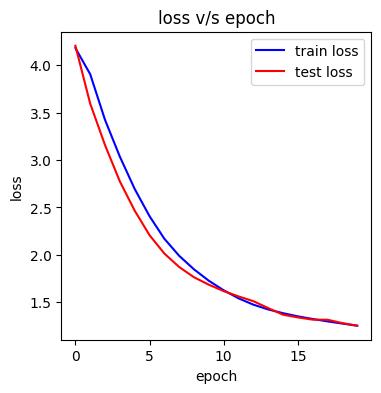

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.plot(train_losses, 'b-', label='train loss')
plt.plot(test_losses , 'r-', label='test loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss v/s epoch')
plt.show()

### hyperparams 2

In [28]:
INPUT_DIM = 29
OUTPUT_DIM = 66
ENC_EMB_DIM = 64
DEC_EMB_DIM = 64
HID_DIM = 64
N_LAYERS = 3
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, 'LSTM')
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, 'LSTM')

model2 = Seq2Seq(enc, dec, device).to(device)

In [29]:
optimizer = optim.Adam(model2.parameters(), lr = 3e-5)

In [30]:
criterion = nn.CrossEntropyLoss(ignore_index = 64)  #ignore EOS token

In [31]:
N_EPOCHS = 20
CLIP = 1
import time
import math
best_test_loss = float('inf')
train_losses_2 = []
test_losses_2 = []
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model2, train_loader, optimizer, criterion, CLIP)
    test_loss = evaluate(model2, test_loader, criterion)
    end_time = time.time()
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model2.state_dict(), '/content/drive/MyDrive/Deep Learning/DL_ops_A2/seq2seq-model_lstm_64_3e-5.pt')
    train_losses_2.append(train_loss)
    test_losses_2.append(test_loss)

    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {test_loss:.3f}')

Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.73it/s, Loss=2.24]


	Train Loss: 3.618 | Val. Loss: 2.240


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.45it/s, Loss=1.63]


	Train Loss: 1.759 | Val. Loss: 1.629


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.21it/s, Loss=1.49]


	Train Loss: 1.339 | Val. Loss: 1.493


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.56it/s, Loss=1.33]


	Train Loss: 1.231 | Val. Loss: 1.330


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.47it/s, Loss=1.11]


	Train Loss: 1.160 | Val. Loss: 1.111


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.70it/s, Loss=1.05]


	Train Loss: 1.116 | Val. Loss: 1.047


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.65it/s, Loss=1.03]


	Train Loss: 1.088 | Val. Loss: 1.026


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.79it/s, Loss=0.989]


	Train Loss: 1.068 | Val. Loss: 0.989


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.33it/s, Loss=0.979]


	Train Loss: 1.054 | Val. Loss: 0.979


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.43it/s, Loss=0.973]


	Train Loss: 1.043 | Val. Loss: 0.973


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.96it/s, Loss=0.956]


	Train Loss: 1.036 | Val. Loss: 0.956


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.68it/s, Loss=0.96]


	Train Loss: 1.030 | Val. Loss: 0.960


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.51it/s, Loss=0.953]


	Train Loss: 1.025 | Val. Loss: 0.953


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.16it/s, Loss=0.947]


	Train Loss: 1.021 | Val. Loss: 0.947


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.17it/s, Loss=0.941]


	Train Loss: 1.018 | Val. Loss: 0.941


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.01it/s, Loss=0.941]


	Train Loss: 1.015 | Val. Loss: 0.941


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  9.00it/s, Loss=0.937]


	Train Loss: 1.012 | Val. Loss: 0.937


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.31it/s, Loss=0.935]


	Train Loss: 1.010 | Val. Loss: 0.935


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.55it/s, Loss=0.931]


	Train Loss: 1.008 | Val. Loss: 0.931


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.37it/s, Loss=0.932]

	Train Loss: 1.007 | Val. Loss: 0.932


In [ ]:
evaluate_acc(model2,test_loader)

0.7394135939582408

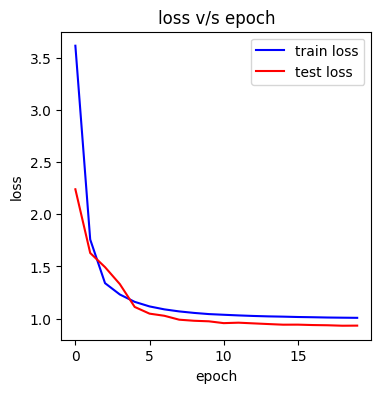

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.plot(train_losses_2, 'b-', label='train loss')
plt.plot(test_losses_2 , 'r-', label='test loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss v/s epoch')
plt.show()

In [ ]:
# saved_model_path = '/content/drive/MyDrive/Deep Learning/DL_ops_A2/seq2seq-model_hp64.pt'
# INPUT_DIM = 29
# OUTPUT_DIM = 66
# ENC_EMB_DIM = 64
# DEC_EMB_DIM = 64
# HID_DIM = 64
# N_LAYERS = 3
# ENC_DROPOUT = 0.25
# DEC_DROPOUT = 0.25

# enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
# dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
# model = Seq2Seq(enc, dec, device).to(device)
# model.load_state_dict(torch.load(saved_model_path))
# model.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(29, 64)
    (rnn): LSTM(64, 64, num_layers=3, dropout=0.25)
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(66, 64)
    (rnn): LSTM(64, 64, num_layers=3, dropout=0.25)
    (fc_out): Linear(in_features=64, out_features=66, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
  )
)

### without dropout

In [34]:
INPUT_DIM = 29
OUTPUT_DIM = 66
ENC_EMB_DIM = 16
DEC_EMB_DIM = 16
HID_DIM = 16
N_LAYERS = 1
ENC_DROPOUT = 0
DEC_DROPOUT = 0

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, 'LSTM')
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, 'LSTM')

model5 = Seq2Seq(enc, dec, device).to(device)

In [35]:
optimizer = optim.Adam(model5.parameters(), lr = 3e-5)

In [36]:
criterion = nn.CrossEntropyLoss(ignore_index = 64)  #ignore EOS token

In [37]:
N_EPOCHS = 20
CLIP = 1
import time
import math
best_test_loss = float('inf')
train_losses_5 = []
test_losses_5 = []
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model5, train_loader, optimizer, criterion, CLIP)
    test_loss = evaluate(model5, test_loader, criterion)
    end_time = time.time()
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model5.state_dict(), '/content/drive/MyDrive/Deep Learning/DL_ops_A2/seq2seq-model_lstm_16_without_dropout_3e-5.pt')
    train_losses_5.append(train_loss)
    test_losses_5.append(test_loss)

    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {test_loss:.3f}')

Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.15it/s, Loss=4.15]


	Train Loss: 4.211 | Val. Loss: 4.145


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  7.64it/s, Loss=3.94]


	Train Loss: 4.057 | Val. Loss: 3.942


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.06it/s, Loss=3.69]


	Train Loss: 3.841 | Val. Loss: 3.686


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.37it/s, Loss=3.34]


	Train Loss: 3.523 | Val. Loss: 3.338


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  7.77it/s, Loss=3.01]


	Train Loss: 3.186 | Val. Loss: 3.008


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.51it/s, Loss=2.71]


	Train Loss: 2.872 | Val. Loss: 2.712


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.44it/s, Loss=2.46]


	Train Loss: 2.593 | Val. Loss: 2.460


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  7.66it/s, Loss=2.2]


	Train Loss: 2.353 | Val. Loss: 2.199


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.57it/s, Loss=2.01]


	Train Loss: 2.144 | Val. Loss: 2.011


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.68it/s, Loss=1.84]


	Train Loss: 1.960 | Val. Loss: 1.845


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.90it/s, Loss=1.68]


	Train Loss: 1.785 | Val. Loss: 1.685


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  7.73it/s, Loss=1.56]


	Train Loss: 1.624 | Val. Loss: 1.563


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.01it/s, Loss=1.48]


	Train Loss: 1.514 | Val. Loss: 1.480


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.50it/s, Loss=1.41]


	Train Loss: 1.441 | Val. Loss: 1.407


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s, Loss=1.35]


	Train Loss: 1.388 | Val. Loss: 1.348


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.80it/s, Loss=1.32]


	Train Loss: 1.345 | Val. Loss: 1.318


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.92it/s, Loss=1.29]


	Train Loss: 1.310 | Val. Loss: 1.294


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.03it/s, Loss=1.26]


	Train Loss: 1.278 | Val. Loss: 1.257


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.82it/s, Loss=1.24]


	Train Loss: 1.250 | Val. Loss: 1.240


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.34it/s, Loss=1.24]

	Train Loss: 1.224 | Val. Loss: 1.239


In [ ]:
evaluate_acc(model5,test_loader)

0.7184895601954686

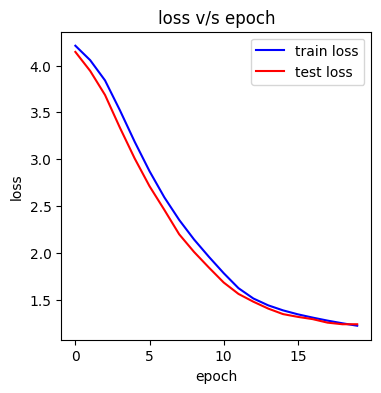

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.plot(train_losses_5, 'b-', label='train loss')
plt.plot(test_losses_5 , 'r-', label='test loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss v/s epoch')
plt.show()

## For RNN

### with hyperparams 1 -16,16,1

In [ ]:
INPUT_DIM = 29
OUTPUT_DIM = 66
ENC_EMB_DIM = 16
DEC_EMB_DIM = 16
HID_DIM = 16
N_LAYERS = 1
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, 'RNN')
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, 'RNN')

model3 = Seq2Seq(enc, dec, device).to(device)

In [ ]:
optimizer = optim.Adam(model3.parameters(), lr = 3e-5)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = 64)  #ignore EOS token

In [ ]:
N_EPOCHS = 20
CLIP = 1
import time
import math
best_test_loss = float('inf')
train_losses_3 = []
test_losses_3 = []
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model3, train_loader, optimizer, criterion, CLIP)
    test_loss = evaluate(model3, test_loader, criterion)
    end_time = time.time()
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model3.state_dict(), '/content/drive/MyDrive/Deep Learning/DL_ops_A2/seq2seq-model_rnn_16_3e-5.pt')
    train_losses_3.append(train_loss)
    test_losses_3.append(test_loss)

    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {test_loss:.3f}')

Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.98it/s, Loss=4.09]


	Train Loss: 4.184 | Val. Loss: 4.089


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.20it/s, Loss=3.59]


	Train Loss: 3.959 | Val. Loss: 3.587


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.55it/s, Loss=3.13]


	Train Loss: 3.533 | Val. Loss: 3.129


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.83it/s, Loss=2.71]


	Train Loss: 3.076 | Val. Loss: 2.715


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.29it/s, Loss=2.37]


	Train Loss: 2.680 | Val. Loss: 2.367


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.51it/s, Loss=2.11]


	Train Loss: 2.351 | Val. Loss: 2.113


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.68it/s, Loss=1.93]


	Train Loss: 2.099 | Val. Loss: 1.933


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.34it/s, Loss=1.81]


	Train Loss: 1.916 | Val. Loss: 1.811


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.24it/s, Loss=1.74]


	Train Loss: 1.793 | Val. Loss: 1.736


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.50it/s, Loss=1.7]


	Train Loss: 1.718 | Val. Loss: 1.696


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.79it/s, Loss=1.67]


	Train Loss: 1.669 | Val. Loss: 1.667


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.32it/s, Loss=1.65]


	Train Loss: 1.633 | Val. Loss: 1.649


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.31it/s, Loss=1.64]


	Train Loss: 1.604 | Val. Loss: 1.639


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.04it/s, Loss=1.63]


	Train Loss: 1.573 | Val. Loss: 1.634


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.18it/s, Loss=1.63]


	Train Loss: 1.544 | Val. Loss: 1.629


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.57it/s, Loss=1.53]


	Train Loss: 1.510 | Val. Loss: 1.528


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.33it/s, Loss=1.52]


	Train Loss: 1.478 | Val. Loss: 1.518


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.67it/s, Loss=1.51]


	Train Loss: 1.452 | Val. Loss: 1.508


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.50it/s, Loss=1.5]


	Train Loss: 1.429 | Val. Loss: 1.504


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.90it/s, Loss=1.5]

	Train Loss: 1.406 | Val. Loss: 1.502


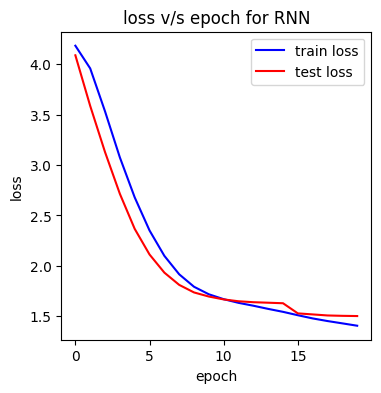

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.plot(train_losses_3, 'b-', label='train loss')
plt.plot(test_losses_3 , 'r-', label='test loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss v/s epoch for RNN')
plt.show()

In [23]:
saved_model_path = '/content/drive/MyDrive/Deep Learning/DL_ops_A2/seq2seq-model_rnn_16_3e-5.pt'
INPUT_DIM = 29
OUTPUT_DIM = 66
ENC_EMB_DIM = 16
DEC_EMB_DIM = 16
HID_DIM = 16
N_LAYERS = 1
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, 'RNN')
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, 'RNN')

model3 = Seq2Seq(enc, dec, device).to(device)
model3.load_state_dict(torch.load(saved_model_path))
model3.eval()

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(29, 16)
    (rnn): RNN(16, 16, dropout=0.25)
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(66, 16)
    (rnn): RNN(16, 16, dropout=0.25)
    (fc_out): Linear(in_features=16, out_features=66, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
  )
)

In [26]:
print('Accuracy : ',evaluate_acc(model3,test_loader))

Accuracy :  0.7190670812972012


### with hyperparams 2- 64,64,3

In [ ]:
INPUT_DIM = 29
OUTPUT_DIM = 66
ENC_EMB_DIM = 64
DEC_EMB_DIM = 64
HID_DIM = 64
N_LAYERS = 3
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, 'RNN')
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, 'RNN')

model4 = Seq2Seq(enc, dec, device).to(device)

In [ ]:
optimizer = optim.Adam(model4.parameters(), lr = 3e-5)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = 64)  #ignore EOS token

In [ ]:
N_EPOCHS = 20
CLIP = 1
import time
import math
best_test_loss = float('inf')
train_losses_4 = []
test_losses_4 = []
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model4, train_loader, optimizer, criterion, CLIP)
    test_loss = evaluate(model4, test_loader, criterion)
    end_time = time.time()
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model4.state_dict(), '/content/drive/MyDrive/Deep Learning/DL_ops_A2/seq2seq-model_rnn_64_3e-5.pt')
    train_losses_4.append(train_loss)
    test_losses_4.append(test_loss)

    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {test_loss:.3f}')

Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.36it/s, Loss=1.97]


	Train Loss: 3.110 | Val. Loss: 1.968


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.67it/s, Loss=1.62]


	Train Loss: 1.744 | Val. Loss: 1.618


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.53it/s, Loss=1.56]


	Train Loss: 1.489 | Val. Loss: 1.560


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.69it/s, Loss=1.25]


	Train Loss: 1.301 | Val. Loss: 1.255


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.60it/s, Loss=1.25]


	Train Loss: 1.219 | Val. Loss: 1.252


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.51it/s, Loss=1.29]


	Train Loss: 1.160 | Val. Loss: 1.287


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.62it/s, Loss=1.23]


	Train Loss: 1.122 | Val. Loss: 1.231


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.44it/s, Loss=1.22]


	Train Loss: 1.100 | Val. Loss: 1.219


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.64it/s, Loss=1.26]


	Train Loss: 1.083 | Val. Loss: 1.256


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.40it/s, Loss=1.29]


	Train Loss: 1.069 | Val. Loss: 1.291


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.50it/s, Loss=1.36]


	Train Loss: 1.058 | Val. Loss: 1.363


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.57it/s, Loss=1.22]


	Train Loss: 1.049 | Val. Loss: 1.218


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.59it/s, Loss=1.25]


	Train Loss: 1.043 | Val. Loss: 1.251


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.60it/s, Loss=1.13]


	Train Loss: 1.039 | Val. Loss: 1.131


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.34it/s, Loss=1.15]


	Train Loss: 1.035 | Val. Loss: 1.148


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.88it/s, Loss=1.1]


	Train Loss: 1.033 | Val. Loss: 1.096


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.20it/s, Loss=1.11]


	Train Loss: 1.030 | Val. Loss: 1.112


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.49it/s, Loss=1.09]


	Train Loss: 1.029 | Val. Loss: 1.085


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.67it/s, Loss=1.1]


	Train Loss: 1.027 | Val. Loss: 1.101


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.23it/s, Loss=1.11]

	Train Loss: 1.024 | Val. Loss: 1.109


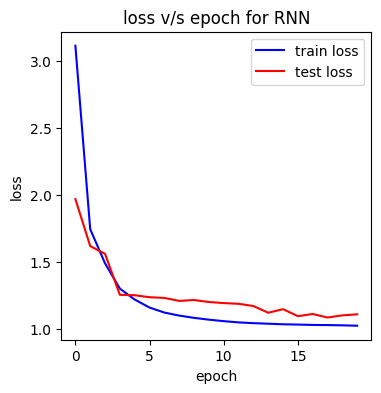

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.plot(train_losses_4, 'b-', label='train loss')
plt.plot(test_losses_4 , 'r-', label='test loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss v/s epoch for RNN')
plt.show()

In [27]:
saved_model_path = '/content/drive/MyDrive/Deep Learning/DL_ops_A2/seq2seq-model_rnn_64_3e-5.pt'
INPUT_DIM = 29
OUTPUT_DIM = 66
ENC_EMB_DIM = 64
DEC_EMB_DIM = 64
HID_DIM = 64
N_LAYERS = 3
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, 'RNN')
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, 'RNN')

model4 = Seq2Seq(enc, dec, device).to(device)
model4.load_state_dict(torch.load(saved_model_path))
model4.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(29, 64)
    (rnn): RNN(64, 64, num_layers=3, dropout=0.25)
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(66, 64)
    (rnn): RNN(64, 64, num_layers=3, dropout=0.25)
    (fc_out): Linear(in_features=64, out_features=66, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
  )
)

In [28]:
print('Accuracy : ',evaluate_acc(model4,test_loader))

Accuracy :  0.7365881830297646


### without dropout

In [ ]:
INPUT_DIM = 29
OUTPUT_DIM = 66
ENC_EMB_DIM = 16
DEC_EMB_DIM = 16
HID_DIM = 16
N_LAYERS = 1
ENC_DROPOUT = 0
DEC_DROPOUT = 0

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, 'RNN')
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, 'RNN')

model6 = Seq2Seq(enc, dec, device).to(device)

In [ ]:
optimizer = optim.Adam(model6.parameters(), lr = 3e-5)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = 64)  #ignore EOS token

In [ ]:
N_EPOCHS = 20
CLIP = 1
import time
import math
best_test_loss = float('inf')
train_losses_6 = []
test_losses_6 = []
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model6, train_loader, optimizer, criterion, CLIP)
    test_loss = evaluate(model6, test_loader, criterion)
    end_time = time.time()
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model6.state_dict(), '/content/drive/MyDrive/Deep Learning/DL_ops_A2/seq2seq-model_rnn_without_dropout_3e-5.pt')
    train_losses_6.append(train_loss)
    test_losses_6.append(test_loss)

    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {test_loss:.3f}')

Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.17it/s, Loss=3.82]


	Train Loss: 4.133 | Val. Loss: 3.819


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.19it/s, Loss=3.73]


	Train Loss: 3.885 | Val. Loss: 3.732


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.08it/s, Loss=3.01]


	Train Loss: 3.317 | Val. Loss: 3.006


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.52it/s, Loss=2.58]


	Train Loss: 2.833 | Val. Loss: 2.575


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.28it/s, Loss=2.24]


	Train Loss: 2.450 | Val. Loss: 2.245


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.15it/s, Loss=2.01]


	Train Loss: 2.162 | Val. Loss: 2.008


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.01it/s, Loss=1.85]


	Train Loss: 1.957 | Val. Loss: 1.847


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.11it/s, Loss=1.74]


	Train Loss: 1.816 | Val. Loss: 1.742


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.36it/s, Loss=1.69]


	Train Loss: 1.725 | Val. Loss: 1.686


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.45it/s, Loss=1.65]


	Train Loss: 1.670 | Val. Loss: 1.654


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.18it/s, Loss=1.63]


	Train Loss: 1.631 | Val. Loss: 1.634


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.85it/s, Loss=1.62]


	Train Loss: 1.600 | Val. Loss: 1.620


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.45it/s, Loss=1.51]


	Train Loss: 1.551 | Val. Loss: 1.511


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.25it/s, Loss=1.49]


	Train Loss: 1.517 | Val. Loss: 1.488


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.29it/s, Loss=1.46]


	Train Loss: 1.493 | Val. Loss: 1.464


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.12it/s, Loss=1.45]


	Train Loss: 1.468 | Val. Loss: 1.448


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.87it/s, Loss=1.44]


	Train Loss: 1.446 | Val. Loss: 1.438


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.45it/s, Loss=1.43]


	Train Loss: 1.423 | Val. Loss: 1.430


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.29it/s, Loss=1.43]


	Train Loss: 1.404 | Val. Loss: 1.426


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.84it/s, Loss=1.41]

	Train Loss: 1.383 | Val. Loss: 1.412


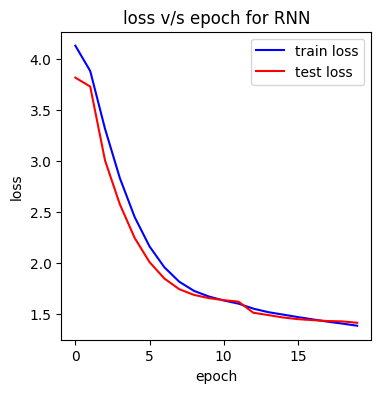

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.plot(train_losses_6, 'b-', label='train loss')
plt.plot(test_losses_6 , 'r-', label='test loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss v/s epoch for RNN')
plt.show()

In [29]:
saved_model_path = '/content/drive/MyDrive/Deep Learning/DL_ops_A2/seq2seq-model_rnn_without_dropout_3e-5.pt'
INPUT_DIM = 29
OUTPUT_DIM = 66
ENC_EMB_DIM = 16
DEC_EMB_DIM = 16
HID_DIM = 16
N_LAYERS = 1
ENC_DROPOUT = 0
DEC_DROPOUT = 0

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, 'RNN')
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, 'RNN')

model6 = Seq2Seq(enc, dec, device).to(device)
model6.load_state_dict(torch.load(saved_model_path))
model6.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(29, 16)
    (rnn): RNN(16, 16)
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(66, 16)
    (rnn): RNN(16, 16)
    (fc_out): Linear(in_features=16, out_features=66, bias=True)
    (dropout): Dropout(p=0, inplace=False)
  )
)

In [30]:
print('Accuracy : ',evaluate_acc(model6,test_loader))

Accuracy :  0.7181252776543758


## Adding Attention

In [24]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout, cell_type='LSTM'):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.cell_type = cell_type
        if cell_type == 'LSTM':
            self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        elif cell_type == 'RNN':
            self.rnn = nn.RNN(emb_dim, hid_dim, n_layers, dropout=dropout)
        else:
            raise ValueError(f"Invalid cell type: {cell_type}")
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

        ## attention Linear Layers
        self.attention = nn.Linear(hid_dim, 25)
        self.attention_combined = nn.Linear(2*hid_dim, hid_dim)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input)) 
        if self.cell_type == 'LSTM':
          output, (hidden, cell) = self.lstm(embedded, (hidden, cell))

          ## attention added
          attention_weights = self.attention(output)
          attention_weights = self.softmax(attention_weights)
          attention_applied = torch.bmm(attention_weights, output)
          output_combined = torch.cat([output, attention_applied], dim=2)
          output_combined = self.attention_combined(output_combined)

          prediction = self.softmax(self.fc_out(output_combined)).squeeze(0)
          return prediction, hidden, cell
        else:  # Using RNN
          output, hidden = self.rnn(embedded, hidden)
          prediction = self.fc_out(output.squeeze(0))
          return prediction, hidden, None

### LSTM - hyperparams1 (16,16,1)

In [30]:
INPUT_DIM = 29
OUTPUT_DIM = 66
ENC_EMB_DIM = 16
DEC_EMB_DIM = 16
HID_DIM = 16
N_LAYERS = 1
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, 'LSTM')
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, 'LSTM')

model7 = Seq2Seq(enc, dec, device).to(device)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [31]:
optimizer = optim.Adam(model7.parameters(), lr = 3e-5)

In [32]:
criterion = nn.CrossEntropyLoss(ignore_index = 64)  #ignore EOS token

In [33]:
N_EPOCHS = 20
CLIP = 1
import time
import math
best_test_loss = float('inf')
train_losses_7 = []
test_losses_7 = []
train_accs_7 = []
test_accs_7 = []
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model7, train_loader, optimizer, criterion, CLIP)
    test_loss, test_acc = evaluate(model7, test_loader, criterion)
    end_time = time.time()
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model7.state_dict(), '/content/drive/MyDrive/Deep Learning/DL_ops_A2/seq2seq-model_lstm_16_attn')
    train_losses_7.append(train_loss)
    test_losses_7.append(test_loss)
    train_accs_7.append(train_acc)
    test_accs_7.append(test_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {test_loss:.3f} | Train acc : {train_acc:.3f}| Test acc : {test_acc:.3f}')

Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.68it/s, Loss=4.21]


	Train Loss: 4.174 | Val. Loss: 4.214 | Train acc : 7.570| Test acc : 8.950


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.49it/s, Loss=3.92]


	Train Loss: 4.051 | Val. Loss: 3.917 | Train acc : 34.875| Test acc : 59.938


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.44it/s, Loss=3.57]


	Train Loss: 3.733 | Val. Loss: 3.565 | Train acc : 31.178| Test acc : 0.477


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.34it/s, Loss=2.29]


	Train Loss: 2.736 | Val. Loss: 2.285 | Train acc : 36.821| Test acc : 56.794


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  7.34it/s, Loss=1.9]


	Train Loss: 1.876 | Val. Loss: 1.899 | Train acc : 55.689| Test acc : 68.442


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.62it/s, Loss=1.3]


	Train Loss: 1.397 | Val. Loss: 1.299 | Train acc : 67.506| Test acc : 69.787


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.72it/s, Loss=1.27]


	Train Loss: 1.339 | Val. Loss: 1.269 | Train acc : 67.975| Test acc : 69.823


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.31it/s, Loss=1.27]


	Train Loss: 1.314 | Val. Loss: 1.274 | Train acc : 67.972| Test acc : 69.792


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.67it/s, Loss=1.28]


	Train Loss: 1.298 | Val. Loss: 1.282 | Train acc : 67.874| Test acc : 69.704


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  7.35it/s, Loss=1.3]


	Train Loss: 1.280 | Val. Loss: 1.298 | Train acc : 67.783| Test acc : 69.563


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.70it/s, Loss=1.34]


	Train Loss: 1.269 | Val. Loss: 1.338 | Train acc : 67.688| Test acc : 69.531


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.19it/s, Loss=1.32]


	Train Loss: 1.260 | Val. Loss: 1.318 | Train acc : 67.773| Test acc : 69.414


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.52it/s, Loss=1.28]


	Train Loss: 1.254 | Val. Loss: 1.281 | Train acc : 67.866| Test acc : 69.389


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.58it/s, Loss=1.26]


	Train Loss: 1.251 | Val. Loss: 1.257 | Train acc : 67.909| Test acc : 69.636


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  7.50it/s, Loss=1.27]


	Train Loss: 1.247 | Val. Loss: 1.275 | Train acc : 67.939| Test acc : 69.446


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.84it/s, Loss=1.28]


	Train Loss: 1.245 | Val. Loss: 1.276 | Train acc : 67.967| Test acc : 69.453


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.77it/s, Loss=1.27]


	Train Loss: 1.242 | Val. Loss: 1.270 | Train acc : 68.004| Test acc : 69.494


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  7.29it/s, Loss=1.27]


	Train Loss: 1.240 | Val. Loss: 1.268 | Train acc : 68.025| Test acc : 69.514


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.48it/s, Loss=1.26]


	Train Loss: 1.238 | Val. Loss: 1.257 | Train acc : 68.042| Test acc : 69.466


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.12it/s, Loss=1.25]


	Train Loss: 1.238 | Val. Loss: 1.250 | Train acc : 68.040| Test acc : 69.506


In [34]:
print('Accuracy : ',evaluate_acc(model7, test_loader))

Accuracy :  0.6901554864504664


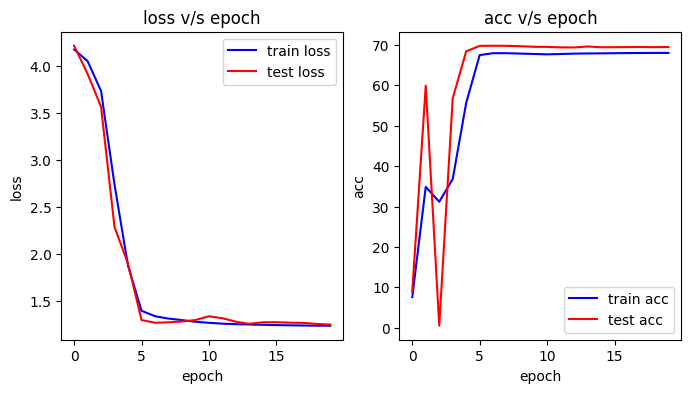

In [35]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first subplot for loss vs epoch
axs[0].plot(train_losses_7, 'b-', label='train loss')
axs[0].plot(test_losses_7 , 'r-', label='test loss')
axs[0].legend()
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].set_title('loss v/s epoch')

# Plot the second subplot for acc vs epoch
axs[1].plot(train_accs_7, 'b-', label='train acc')
axs[1].plot(test_accs_7 , 'r-', label='test acc')
axs[1].legend()
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('acc')
axs[1].set_title('acc v/s epoch')

# Show the plot
plt.show()


### LSTM hyperparams2 - 64,64,3

In [36]:
INPUT_DIM = 29
OUTPUT_DIM = 66
ENC_EMB_DIM = 64
DEC_EMB_DIM = 64
HID_DIM = 64
N_LAYERS = 3
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, 'LSTM')
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, 'LSTM')

model8 = Seq2Seq(enc, dec, device).to(device)

In [37]:
optimizer = optim.Adam(model8.parameters(), lr = 3e-5)

In [38]:
criterion = nn.CrossEntropyLoss(ignore_index = 64)  #ignore EOS token

In [39]:
N_EPOCHS = 20
CLIP = 1
import time
import math
best_test_loss = float('inf')
train_losses_8 = []
test_losses_8 = []
train_accs_8 = []
test_accs_8 = []
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model8, train_loader, optimizer, criterion, CLIP)
    test_loss, test_acc = evaluate(model8, test_loader, criterion)
    end_time = time.time()
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model8.state_dict(), '/content/drive/MyDrive/Deep Learning/DL_ops_A2/seq2seq-model_lstm_64_attn')
    train_losses_8.append(train_loss)
    test_losses_8.append(test_loss)
    train_accs_8.append(train_acc)
    test_accs_8.append(test_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {test_loss:.3f} | Train acc : {train_acc:.3f}| Test acc : {test_acc:.3f}')

Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.20it/s, Loss=1.72]


	Train Loss: 3.566 | Val. Loss: 1.721 | Train acc : 47.864| Test acc : 68.220


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.17it/s, Loss=1.4]


	Train Loss: 1.357 | Val. Loss: 1.398 | Train acc : 67.924| Test acc : 69.620


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.31it/s, Loss=1.79]


	Train Loss: 1.236 | Val. Loss: 1.791 | Train acc : 68.319| Test acc : 68.055


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.16it/s, Loss=1.72]


	Train Loss: 1.234 | Val. Loss: 1.720 | Train acc : 71.794| Test acc : 68.751


Evaluation: 100%|██████████| 36/36 [00:05<00:00,  7.07it/s, Loss=1.5]


	Train Loss: 1.230 | Val. Loss: 1.501 | Train acc : 71.006| Test acc : 70.000


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.19it/s, Loss=1.75]


	Train Loss: 1.225 | Val. Loss: 1.753 | Train acc : 69.960| Test acc : 65.222


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.37it/s, Loss=1.29]


	Train Loss: 1.220 | Val. Loss: 1.286 | Train acc : 71.467| Test acc : 73.131


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.19it/s, Loss=1.24]


	Train Loss: 1.215 | Val. Loss: 1.235 | Train acc : 72.202| Test acc : 73.274


Evaluation: 100%|██████████| 36/36 [00:05<00:00,  6.98it/s, Loss=1.21]


	Train Loss: 1.212 | Val. Loss: 1.214 | Train acc : 72.221| Test acc : 71.783


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  7.64it/s, Loss=1.19]


	Train Loss: 1.209 | Val. Loss: 1.189 | Train acc : 72.283| Test acc : 73.881


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.75it/s, Loss=1.2]


	Train Loss: 1.206 | Val. Loss: 1.198 | Train acc : 72.348| Test acc : 74.032


Evaluation: 100%|██████████| 36/36 [00:05<00:00,  6.60it/s, Loss=1.18]


	Train Loss: 1.204 | Val. Loss: 1.177 | Train acc : 72.416| Test acc : 74.073


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  7.78it/s, Loss=1.18]


	Train Loss: 1.202 | Val. Loss: 1.183 | Train acc : 72.513| Test acc : 74.203


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.91it/s, Loss=1.19]


	Train Loss: 1.200 | Val. Loss: 1.191 | Train acc : 72.558| Test acc : 74.197


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.07it/s, Loss=1.18]


	Train Loss: 1.198 | Val. Loss: 1.184 | Train acc : 72.562| Test acc : 74.172


Evaluation: 100%|██████████| 36/36 [00:05<00:00,  6.93it/s, Loss=1.15]


	Train Loss: 1.193 | Val. Loss: 1.147 | Train acc : 72.533| Test acc : 74.227


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.02it/s, Loss=1.14]


	Train Loss: 1.188 | Val. Loss: 1.135 | Train acc : 72.510| Test acc : 74.205


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.16it/s, Loss=1.12]


	Train Loss: 1.180 | Val. Loss: 1.116 | Train acc : 72.458| Test acc : 74.115


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.08it/s, Loss=1.08]


	Train Loss: 1.159 | Val. Loss: 1.078 | Train acc : 72.311| Test acc : 73.826


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  7.36it/s, Loss=0.997]

	Train Loss: 1.094 | Val. Loss: 0.997 | Train acc : 72.100| Test acc : 73.882


In [40]:
print('Accuracy : ',evaluate_acc(model8, test_loader))

Accuracy :  0.7331674811195024


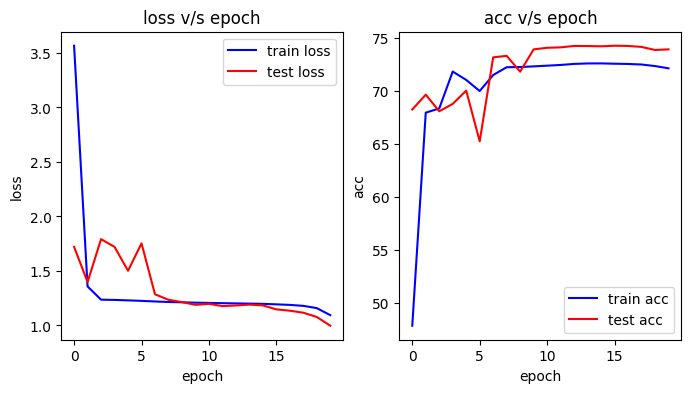

In [41]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first subplot for loss vs epoch
axs[0].plot(train_losses_8, 'b-', label='train loss')
axs[0].plot(test_losses_8 , 'r-', label='test loss')
axs[0].legend()
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].set_title('loss v/s epoch')

# Plot the second subplot for acc vs epoch
axs[1].plot(train_accs_8, 'b-', label='train acc')
axs[1].plot(test_accs_8 , 'r-', label='test acc')
axs[1].legend()
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('acc')
axs[1].set_title('acc v/s epoch')

# Show the plot
plt.show()


### without dropout LSTM and attn

In [42]:
INPUT_DIM = 29
OUTPUT_DIM = 66
ENC_EMB_DIM = 16
DEC_EMB_DIM = 16
HID_DIM = 16
N_LAYERS = 1
ENC_DROPOUT = 0
DEC_DROPOUT = 0

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, 'LSTM')
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, 'LSTM')

model9 = Seq2Seq(enc, dec, device).to(device)

In [43]:
optimizer = optim.Adam(model9.parameters(), lr = 3e-5)

In [44]:
criterion = nn.CrossEntropyLoss(ignore_index = 64)  #ignore EOS token

In [45]:
N_EPOCHS = 20
CLIP = 1
import time
import math
best_test_loss = float('inf')
train_losses_9 = []
test_losses_9 = []
train_accs_9 = []
test_accs_9 = []
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model9, train_loader, optimizer, criterion, CLIP)
    test_loss, test_acc = evaluate(model9, test_loader, criterion)
    end_time = time.time()
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model9.state_dict(), '/content/drive/MyDrive/Deep Learning/DL_ops_A2/seq2seq-model_lstm_16_no_dropout_attn')
    train_losses_9.append(train_loss)
    test_losses_9.append(test_loss)
    train_accs_9.append(train_acc)
    test_accs_9.append(test_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {test_loss:.3f} | Train acc : {train_acc:.3f}| Test acc : {test_acc:.3f}')

Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.50it/s, Loss=4.14]


	Train Loss: 4.165 | Val. Loss: 4.141 | Train acc : 20.343| Test acc : 61.103


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.61it/s, Loss=3.95]


	Train Loss: 4.026 | Val. Loss: 3.953 | Train acc : 54.973| Test acc : 61.117


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  7.68it/s, Loss=3.55]


	Train Loss: 3.752 | Val. Loss: 3.548 | Train acc : 52.129| Test acc : 58.948


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.61it/s, Loss=2.75]


	Train Loss: 2.987 | Val. Loss: 2.749 | Train acc : 53.380| Test acc : 60.294


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.43it/s, Loss=1.7]


	Train Loss: 1.914 | Val. Loss: 1.704 | Train acc : 61.354| Test acc : 66.277


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  7.47it/s, Loss=1.42]


	Train Loss: 1.402 | Val. Loss: 1.418 | Train acc : 67.299| Test acc : 69.419


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.80it/s, Loss=1.37]


	Train Loss: 1.326 | Val. Loss: 1.372 | Train acc : 67.892| Test acc : 69.569


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.21it/s, Loss=1.34]


	Train Loss: 1.306 | Val. Loss: 1.339 | Train acc : 67.947| Test acc : 69.625


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.19it/s, Loss=1.32]


	Train Loss: 1.294 | Val. Loss: 1.318 | Train acc : 67.906| Test acc : 69.609


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  7.97it/s, Loss=1.31]


	Train Loss: 1.284 | Val. Loss: 1.307 | Train acc : 67.875| Test acc : 69.632


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.44it/s, Loss=1.3]


	Train Loss: 1.275 | Val. Loss: 1.302 | Train acc : 67.858| Test acc : 69.648


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.57it/s, Loss=1.28]


	Train Loss: 1.266 | Val. Loss: 1.278 | Train acc : 67.852| Test acc : 69.650


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  7.57it/s, Loss=1.24]


	Train Loss: 1.259 | Val. Loss: 1.243 | Train acc : 67.824| Test acc : 69.609


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.98it/s, Loss=1.23]


	Train Loss: 1.249 | Val. Loss: 1.234 | Train acc : 67.882| Test acc : 69.590


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.60it/s, Loss=1.23]


	Train Loss: 1.243 | Val. Loss: 1.228 | Train acc : 67.932| Test acc : 69.666


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.49it/s, Loss=1.24]


	Train Loss: 1.239 | Val. Loss: 1.239 | Train acc : 68.032| Test acc : 69.674


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  7.31it/s, Loss=1.24]


	Train Loss: 1.236 | Val. Loss: 1.237 | Train acc : 68.069| Test acc : 69.689


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.53it/s, Loss=1.26]


	Train Loss: 1.234 | Val. Loss: 1.256 | Train acc : 68.113| Test acc : 69.704


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.27it/s, Loss=1.25]


	Train Loss: 1.233 | Val. Loss: 1.245 | Train acc : 68.092| Test acc : 69.704


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.34it/s, Loss=1.25]

	Train Loss: 1.231 | Val. Loss: 1.251 | Train acc : 68.114| Test acc : 69.737


In [46]:
print('Accuracy : ',evaluate_acc(model9, test_loader))

Accuracy :  0.6922789871168369


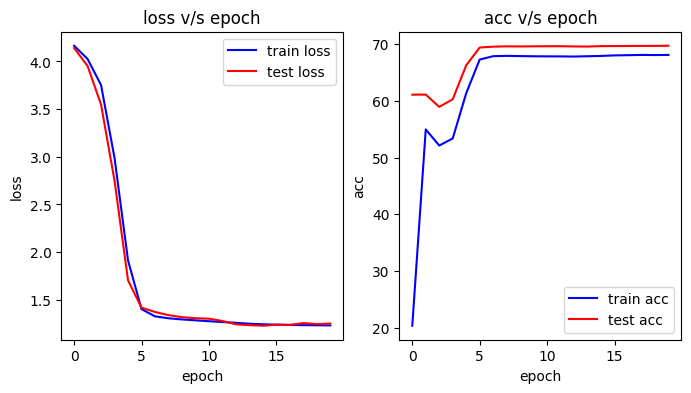

In [47]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first subplot for loss vs epoch
axs[0].plot(train_losses_9, 'b-', label='train loss')
axs[0].plot(test_losses_9 , 'r-', label='test loss')
axs[0].legend()
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].set_title('loss v/s epoch')

# Plot the second subplot for acc vs epoch
axs[1].plot(train_accs_9, 'b-', label='train acc')
axs[1].plot(test_accs_9 , 'r-', label='test acc')
axs[1].legend()
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('acc')
axs[1].set_title('acc v/s epoch')

# Show the plot
plt.show()


### RNN - hyperparams1 (16,16,1)

In [25]:
INPUT_DIM = 29
OUTPUT_DIM = 66
ENC_EMB_DIM = 16
DEC_EMB_DIM = 16
HID_DIM = 16
N_LAYERS = 1
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, 'RNN')
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, 'RNN')

model10 = Seq2Seq(enc, dec, device).to(device)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [26]:
optimizer = optim.Adam(model10.parameters(), lr = 3e-5)

In [27]:
criterion = nn.CrossEntropyLoss(ignore_index = 64)  #ignore EOS token

In [28]:
N_EPOCHS = 20
CLIP = 1
import time
import math
best_test_loss = float('inf')
train_losses_10 = []
test_losses_10 = []
train_accs_10 = []
test_accs_10 = []
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model10, train_loader, optimizer, criterion, CLIP)
    test_loss, test_acc = evaluate(model10, test_loader, criterion)
    end_time = time.time()
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model10.state_dict(), '/content/drive/MyDrive/Deep Learning/DL_ops_A2/seq2seq-model_rnn_16_attn')
    train_losses_10.append(train_loss)
    test_losses_10.append(test_loss)
    train_accs_10.append(train_acc)
    test_accs_10.append(test_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {test_loss:.3f} | Train acc : {train_acc:.3f}| Test acc : {test_acc:.3f}')

Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.00it/s, Loss=4.22]


	Train Loss: 3.975 | Val. Loss: 4.216 | Train acc : 3.801| Test acc : 0.262


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.00it/s, Loss=3.22]


	Train Loss: 3.546 | Val. Loss: 3.215 | Train acc : 47.194| Test acc : 66.734


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.88it/s, Loss=2.8]


	Train Loss: 3.099 | Val. Loss: 2.795 | Train acc : 65.385| Test acc : 68.161


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.91it/s, Loss=2.46]


	Train Loss: 2.738 | Val. Loss: 2.457 | Train acc : 66.346| Test acc : 68.288


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.62it/s, Loss=2.18]


	Train Loss: 2.415 | Val. Loss: 2.176 | Train acc : 66.714| Test acc : 68.373


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.70it/s, Loss=1.96]


	Train Loss: 2.144 | Val. Loss: 1.965 | Train acc : 66.904| Test acc : 68.488


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.01it/s, Loss=1.82]


	Train Loss: 1.943 | Val. Loss: 1.822 | Train acc : 66.988| Test acc : 68.490


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.61it/s, Loss=1.73]


	Train Loss: 1.802 | Val. Loss: 1.731 | Train acc : 67.090| Test acc : 68.588


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.89it/s, Loss=1.69]


	Train Loss: 1.717 | Val. Loss: 1.687 | Train acc : 67.315| Test acc : 68.493


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.88it/s, Loss=1.66]


	Train Loss: 1.663 | Val. Loss: 1.662 | Train acc : 68.040| Test acc : 68.493


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.61it/s, Loss=1.65]


	Train Loss: 1.619 | Val. Loss: 1.646 | Train acc : 69.416| Test acc : 68.494


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.01it/s, Loss=1.55]


	Train Loss: 1.582 | Val. Loss: 1.555 | Train acc : 69.787| Test acc : 72.494


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.24it/s, Loss=1.53]


	Train Loss: 1.547 | Val. Loss: 1.532 | Train acc : 70.157| Test acc : 72.493


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.94it/s, Loss=1.52]


	Train Loss: 1.515 | Val. Loss: 1.515 | Train acc : 70.542| Test acc : 72.485


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.48it/s, Loss=1.5]


	Train Loss: 1.485 | Val. Loss: 1.500 | Train acc : 70.784| Test acc : 72.486


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.03it/s, Loss=1.49]


	Train Loss: 1.460 | Val. Loss: 1.491 | Train acc : 70.863| Test acc : 72.486


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.06it/s, Loss=1.48]


	Train Loss: 1.435 | Val. Loss: 1.485 | Train acc : 70.929| Test acc : 72.496


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.45it/s, Loss=1.49]


	Train Loss: 1.410 | Val. Loss: 1.486 | Train acc : 70.955| Test acc : 72.495


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.89it/s, Loss=1.49]


	Train Loss: 1.382 | Val. Loss: 1.486 | Train acc : 71.022| Test acc : 72.495


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.65it/s, Loss=1.48]

	Train Loss: 1.344 | Val. Loss: 1.477 | Train acc : 71.148| Test acc : 72.511


In [29]:
print('Accuracy : ',evaluate_acc(model10, test_loader))

Accuracy :  0.7191381608174146


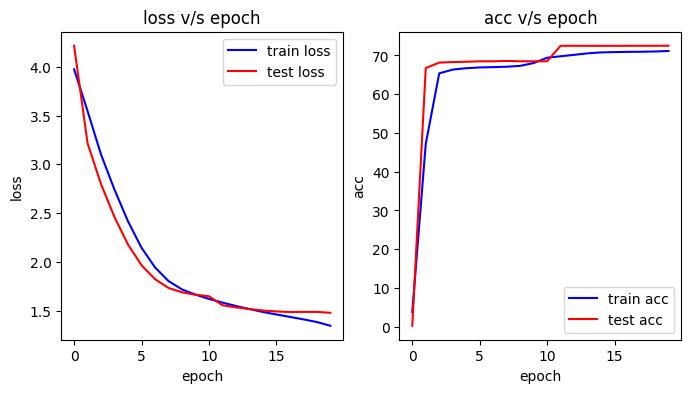

In [30]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first subplot for loss vs epoch
axs[0].plot(train_losses_10, 'b-', label='train loss')
axs[0].plot(test_losses_10 , 'r-', label='test loss')
axs[0].legend()
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].set_title('loss v/s epoch')

# Plot the second subplot for acc vs epoch
axs[1].plot(train_accs_10, 'b-', label='train acc')
axs[1].plot(test_accs_10 , 'r-', label='test acc')
axs[1].legend()
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('acc')
axs[1].set_title('acc v/s epoch')

# Show the plot
plt.show()


### RNN hyperparams2 - 64,64,3

In [31]:
INPUT_DIM = 29
OUTPUT_DIM = 66
ENC_EMB_DIM = 64
DEC_EMB_DIM = 64
HID_DIM = 64
N_LAYERS = 3
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, 'RNN')
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, 'RNN')

model11 = Seq2Seq(enc, dec, device).to(device)

In [32]:
optimizer = optim.Adam(model11.parameters(), lr = 3e-5)

In [33]:
criterion = nn.CrossEntropyLoss(ignore_index = 64)  #ignore EOS token

In [34]:
N_EPOCHS = 20
CLIP = 1
import time
import math
best_test_loss = float('inf')
train_losses_11 = []
test_losses_11 = []
train_accs_11 = []
test_accs_11 = []
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model11, train_loader, optimizer, criterion, CLIP)
    test_loss, test_acc = evaluate(model11, test_loader, criterion)
    end_time = time.time()
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model11.state_dict(), '/content/drive/MyDrive/Deep Learning/DL_ops_A2/seq2seq-model_rnn_64_attn')
    train_losses_11.append(train_loss)
    test_losses_11.append(test_loss)
    train_accs_11.append(train_acc)
    test_accs_11.append(test_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {test_loss:.3f} | Train acc : {train_acc:.3f}| Test acc : {test_acc:.3f}')

Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.42it/s, Loss=1.82]


	Train Loss: 2.905 | Val. Loss: 1.820 | Train acc : 56.886| Test acc : 68.494


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.06it/s, Loss=1.63]


	Train Loss: 1.657 | Val. Loss: 1.632 | Train acc : 67.478| Test acc : 68.495


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.89it/s, Loss=1.5]


	Train Loss: 1.394 | Val. Loss: 1.495 | Train acc : 69.946| Test acc : 72.447


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.34it/s, Loss=1.25]


	Train Loss: 1.276 | Val. Loss: 1.248 | Train acc : 70.040| Test acc : 72.172


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.23it/s, Loss=1.21]


	Train Loss: 1.228 | Val. Loss: 1.215 | Train acc : 70.286| Test acc : 72.336


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.28it/s, Loss=1.24]


	Train Loss: 1.180 | Val. Loss: 1.243 | Train acc : 71.195| Test acc : 72.423


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.95it/s, Loss=1.29]


	Train Loss: 1.127 | Val. Loss: 1.294 | Train acc : 71.859| Test acc : 73.034


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.50it/s, Loss=1.22]


	Train Loss: 1.097 | Val. Loss: 1.220 | Train acc : 72.004| Test acc : 73.235


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.69it/s, Loss=1.13]


	Train Loss: 1.078 | Val. Loss: 1.130 | Train acc : 72.108| Test acc : 73.762


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.36it/s, Loss=1.12]


	Train Loss: 1.064 | Val. Loss: 1.122 | Train acc : 72.228| Test acc : 73.663


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.30it/s, Loss=1.03]


	Train Loss: 1.055 | Val. Loss: 1.026 | Train acc : 72.304| Test acc : 74.181


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.36it/s, Loss=1.01]


	Train Loss: 1.049 | Val. Loss: 1.012 | Train acc : 72.343| Test acc : 74.235


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.32it/s, Loss=1.02]


	Train Loss: 1.043 | Val. Loss: 1.016 | Train acc : 72.393| Test acc : 74.220


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.79it/s, Loss=0.992]


	Train Loss: 1.039 | Val. Loss: 0.992 | Train acc : 72.410| Test acc : 74.210


Evaluation: 100%|██████████| 36/36 [00:04<00:00,  8.14it/s, Loss=1.08]


	Train Loss: 1.036 | Val. Loss: 1.078 | Train acc : 72.430| Test acc : 74.218


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.09it/s, Loss=1.06]


	Train Loss: 1.034 | Val. Loss: 1.059 | Train acc : 72.405| Test acc : 74.248


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.34it/s, Loss=1]


	Train Loss: 1.032 | Val. Loss: 1.004 | Train acc : 72.418| Test acc : 74.258


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.44it/s, Loss=0.995]


	Train Loss: 1.029 | Val. Loss: 0.995 | Train acc : 72.453| Test acc : 74.241


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.32it/s, Loss=1.05]


	Train Loss: 1.029 | Val. Loss: 1.049 | Train acc : 72.454| Test acc : 74.176


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.06it/s, Loss=1.06]

	Train Loss: 1.026 | Val. Loss: 1.059 | Train acc : 72.463| Test acc : 74.182


In [35]:
print('Accuracy : ',evaluate_acc(model11, test_loader))

Accuracy :  0.7362327854286983


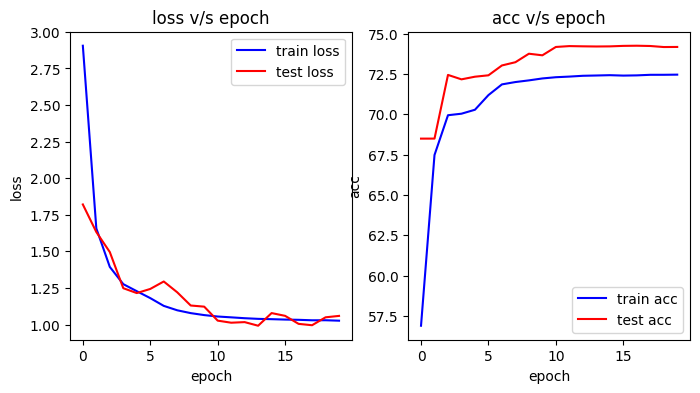

In [36]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first subplot for loss vs epoch
axs[0].plot(train_losses_11, 'b-', label='train loss')
axs[0].plot(test_losses_11 , 'r-', label='test loss')
axs[0].legend()
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].set_title('loss v/s epoch')

# Plot the second subplot for acc vs epoch
axs[1].plot(train_accs_11, 'b-', label='train acc')
axs[1].plot(test_accs_11 , 'r-', label='test acc')
axs[1].legend()
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('acc')
axs[1].set_title('acc v/s epoch')

# Show the plot
plt.show()


### without dropout RNN and attn

In [37]:
INPUT_DIM = 29
OUTPUT_DIM = 66
ENC_EMB_DIM = 16
DEC_EMB_DIM = 16
HID_DIM = 16
N_LAYERS = 1
ENC_DROPOUT = 0
DEC_DROPOUT = 0

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, 'RNN')
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, 'RNN')

model12 = Seq2Seq(enc, dec, device).to(device)

In [38]:
optimizer = optim.Adam(model12.parameters(), lr = 3e-5)

In [39]:
criterion = nn.CrossEntropyLoss(ignore_index = 64)  #ignore EOS token

In [40]:
N_EPOCHS = 20
CLIP = 1
import time
import math
best_test_loss = float('inf')
train_losses_12 = []
test_losses_12 = []
train_accs_12 = []
test_accs_12 = []
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model12, train_loader, optimizer, criterion, CLIP)
    test_loss, test_acc = evaluate(model12, test_loader, criterion)
    end_time = time.time()
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model12.state_dict(), '/content/drive/MyDrive/Deep Learning/DL_ops_A2/seq2seq-model_rnn_16_no_dropout_attn')
    train_losses_12.append(train_loss)
    test_losses_12.append(test_loss)
    train_accs_12.append(train_acc)
    test_accs_12.append(test_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {test_loss:.3f} | Train acc : {train_acc:.3f}| Test acc : {test_acc:.3f}')

Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.97it/s, Loss=4.29]


	Train Loss: 4.216 | Val. Loss: 4.290 | Train acc : 0.449| Test acc : 0.502


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.06it/s, Loss=3.51]


	Train Loss: 3.933 | Val. Loss: 3.514 | Train acc : 7.058| Test acc : 63.293


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.85it/s, Loss=3.03]


	Train Loss: 3.287 | Val. Loss: 3.032 | Train acc : 62.771| Test acc : 66.327


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.15it/s, Loss=2.6]


	Train Loss: 2.896 | Val. Loss: 2.603 | Train acc : 63.999| Test acc : 68.344


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.04it/s, Loss=2.3]


	Train Loss: 2.554 | Val. Loss: 2.297 | Train acc : 64.978| Test acc : 68.377


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.08it/s, Loss=2.05]


	Train Loss: 2.262 | Val. Loss: 2.053 | Train acc : 65.708| Test acc : 68.408


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.53it/s, Loss=1.88]


	Train Loss: 2.028 | Val. Loss: 1.877 | Train acc : 66.379| Test acc : 68.327


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.07it/s, Loss=1.76]


	Train Loss: 1.859 | Val. Loss: 1.755 | Train acc : 66.604| Test acc : 68.455


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.07it/s, Loss=1.69]


	Train Loss: 1.749 | Val. Loss: 1.689 | Train acc : 66.749| Test acc : 68.487


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.99it/s, Loss=1.65]


	Train Loss: 1.688 | Val. Loss: 1.655 | Train acc : 66.845| Test acc : 68.492


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.74it/s, Loss=1.63]


	Train Loss: 1.649 | Val. Loss: 1.635 | Train acc : 66.881| Test acc : 68.494


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.74it/s, Loss=1.62]


	Train Loss: 1.622 | Val. Loss: 1.622 | Train acc : 66.888| Test acc : 68.500


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.95it/s, Loss=1.61]


	Train Loss: 1.598 | Val. Loss: 1.614 | Train acc : 66.910| Test acc : 68.486


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.16it/s, Loss=1.61]


	Train Loss: 1.577 | Val. Loss: 1.610 | Train acc : 66.918| Test acc : 68.479


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.88it/s, Loss=1.6]


	Train Loss: 1.555 | Val. Loss: 1.605 | Train acc : 66.937| Test acc : 68.512


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.30it/s, Loss=1.6]


	Train Loss: 1.534 | Val. Loss: 1.600 | Train acc : 66.948| Test acc : 68.529


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 11.84it/s, Loss=1.61]


	Train Loss: 1.513 | Val. Loss: 1.607 | Train acc : 66.983| Test acc : 68.528


Evaluation: 100%|██████████| 36/36 [00:02<00:00, 12.06it/s, Loss=1.61]


	Train Loss: 1.489 | Val. Loss: 1.608 | Train acc : 67.038| Test acc : 68.528


Evaluation: 100%|██████████| 36/36 [00:03<00:00,  9.30it/s, Loss=1.52]


	Train Loss: 1.428 | Val. Loss: 1.524 | Train acc : 70.331| Test acc : 72.470


Evaluation: 100%|██████████| 36/36 [00:03<00:00, 10.62it/s, Loss=1.51]


	Train Loss: 1.380 | Val. Loss: 1.514 | Train acc : 71.113| Test acc : 72.445


In [41]:
print('Accuracy : ',evaluate_acc(model12, test_loader))

Accuracy :  0.7185606397156818


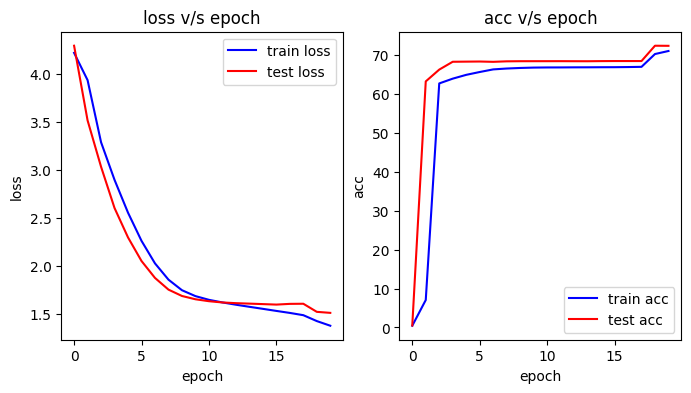

In [42]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first subplot for loss vs epoch
axs[0].plot(train_losses_12, 'b-', label='train loss')
axs[0].plot(test_losses_12 , 'r-', label='test loss')
axs[0].legend()
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].set_title('loss v/s epoch')

# Plot the second subplot for acc vs epoch
axs[1].plot(train_accs_12, 'b-', label='train acc')
axs[1].plot(test_accs_12 , 'r-', label='test acc')
axs[1].legend()
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('acc')
axs[1].set_title('acc v/s epoch')

# Show the plot
plt.show()


<h2> <center> ---------------------------------------------------------------- THANK YOU !! ---------------------------------------------------------------- </center></h2>